In [1]:
from environment.models.simple import SimpleEnv

import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

env = SimpleEnv()


2024-03-20 10:06:48.092779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 10:06:48.151306: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


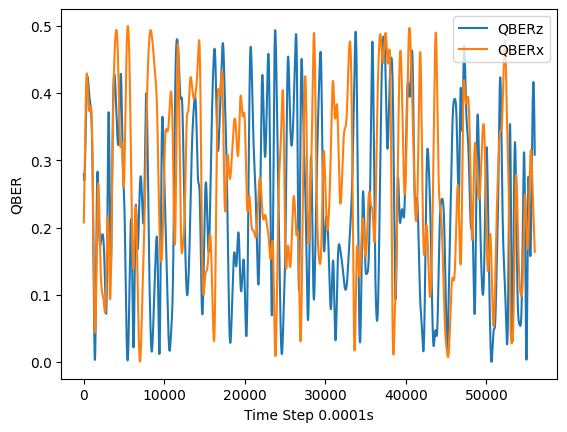

In [37]:
env.simulate(reset=False)

QBER = env.get_QBER()
PHI = env.get_phi()

plt.plot(QBER[:,0],label='QBERz')
plt.plot(QBER[:,1],label='QBERx')
plt.legend(loc = 'upper right')
plt.ylabel('QBER')
plt.xlabel(f'Time Step {env.delta_t}s')
plt.show()

In [38]:
split = .8
train_test_margin = .1
# Split the data into training and testing sets
phi_train = PHI[:int(len(PHI)*split)]
phi_test = PHI[int(len(PHI)*(split-train_test_margin)):]

QBERs_train = QBER[:int(len(QBER)*split)]
QBERs_test = QBER[int(len(QBER)*(split-train_test_margin)):]

# Prepare the input data for RNN
phi_train = phi_train.reshape(phi_train.shape[0], 1, phi_train.shape[1])
phi_test = phi_test.reshape(phi_test.shape[0], 1, phi_test.shape[1])
QBERs_train = QBERs_train.reshape(QBERs_train.shape[0], 1, QBERs_train.shape[1])
QBERs_test = QBERs_test.reshape(QBERs_test.shape[0], 1, QBERs_test.shape[1])

In [53]:
from tqdm import tqdm

# define how many variables
num_inputs = 2

# a model for each phi
models = []
# loop nr of phi angles to consider
for i in tqdm(range(PHI.shape[1]), desc="Training models"):
    # Define the architecture of the neural network
    model = keras.Sequential([
        keras.layers.LSTM(1024, activation='relu', input_shape=(None, num_inputs), return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(512, activation='relu', return_sequences=True),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')

    # Train the neural network
    model.fit(QBERs_train[:,:], phi_train[:,i], epochs=10, batch_size=10, verbose=0)
    
    models.append(model)

    tqdm.write(f"Model for phi {i} trained")

Epoch 1/60
4481/4481 [==============================] - 83s 18ms/step - loss: 1.7166
Epoch 2/60
4481/4481 [==============================] - 81s 18ms/step - loss: 1.5699
Epoch 3/60
4481/4481 [==============================] - 81s 18ms/step - loss: 1.5140
Epoch 4/60
4481/4481 [==============================] - 81s 18ms/step - loss: 1.4798
Epoch 5/60
4481/4481 [==============================] - 82s 18ms/step - loss: 1.4488
Epoch 6/60
4481/4481 [==============================] - 82s 18ms/step - loss: 1.4238
Epoch 7/60
4481/4481 [==============================] - 81s 18ms/step - loss: 1.4014
Epoch 8/60
4481/4481 [==============================] - 82s 18ms/step - loss: 1.3841
Epoch 9/60
4481/4481 [==============================] - 83s 18ms/step - loss: 1.3702
Epoch 10/60
4481/4481 [==============================] - 82s 18ms/step - loss: 1.3594
Epoch 11/60
4481/4481 [==============================] - 82s 18ms/step - loss: 1.3474
Epoch 12/60
3760/4481 [========================>.....] - ETA: 1

In [ ]:
phi_preds = []
for i in tqdm(range(PHI.shape[1]), desc="Training models"):
    # Predict the QBER using the trained neural network
    phi_preds.append(models[i].predict(QBERs_test[:,:], batch_size=1))

# Convert the predicted_phi_move to a numpy array
phi_preds = np.array(phi_preds)

In [40]:
phi_preds = phi_preds.reshape(phi_preds.shape[0], phi_preds.shape[2])
print(phi_preds.shape)
phi_test = phi_test.reshape(phi_test.shape[0], phi_test.shape[2])
print(phi_test.shape)

(16801, 12)
(16801, 12)


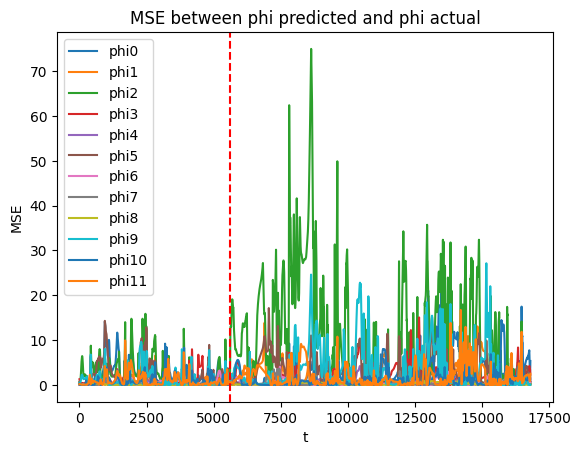

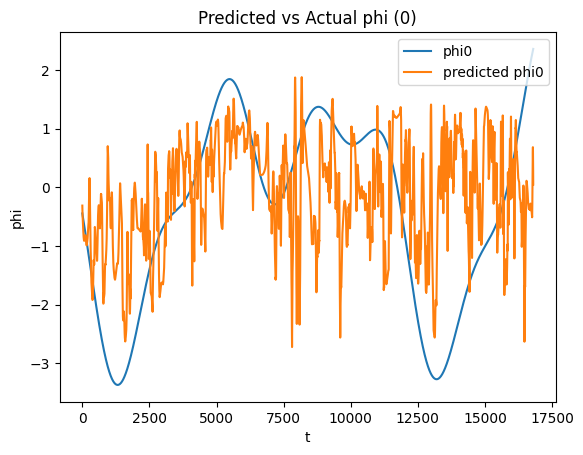

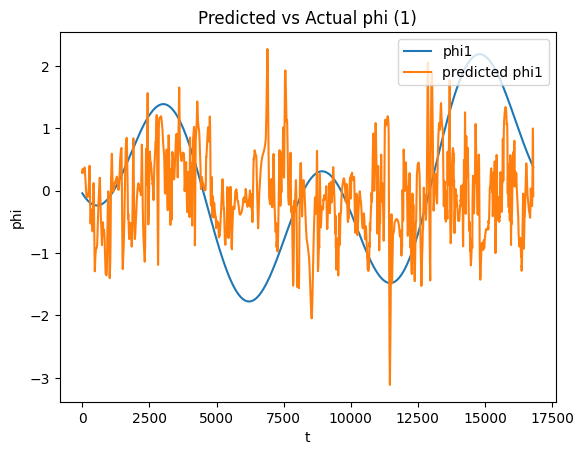

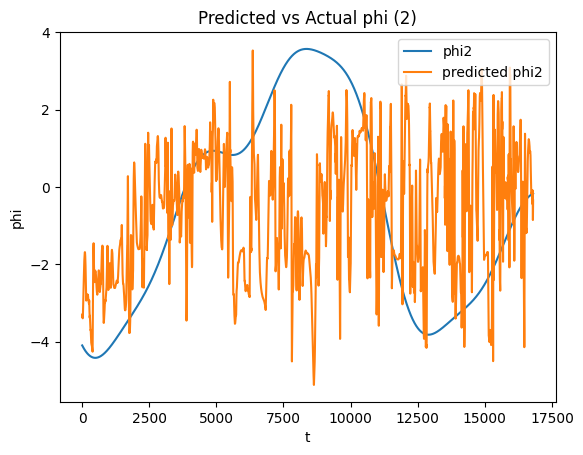

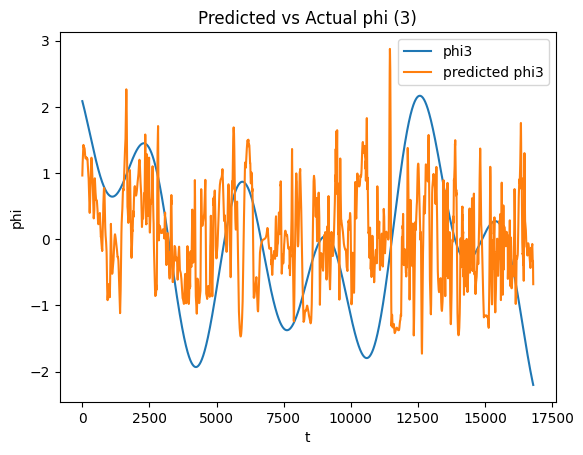

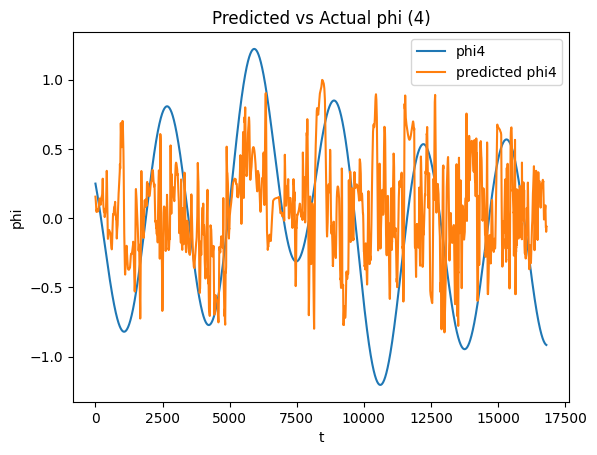

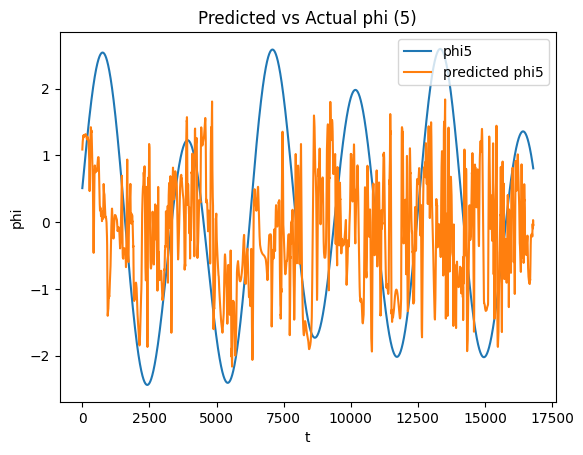

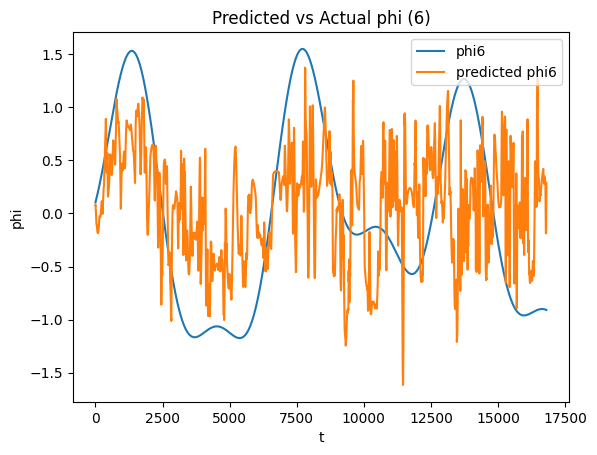

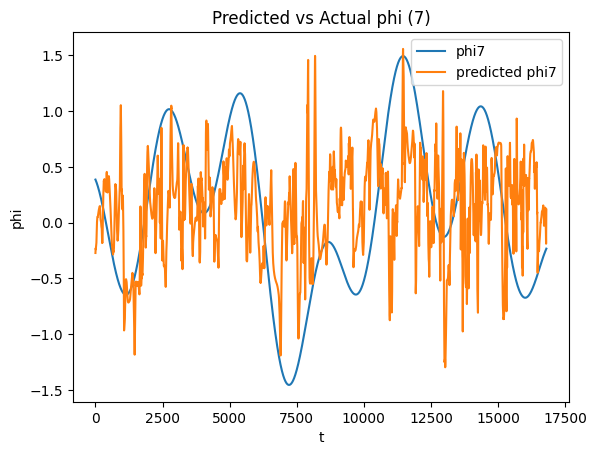

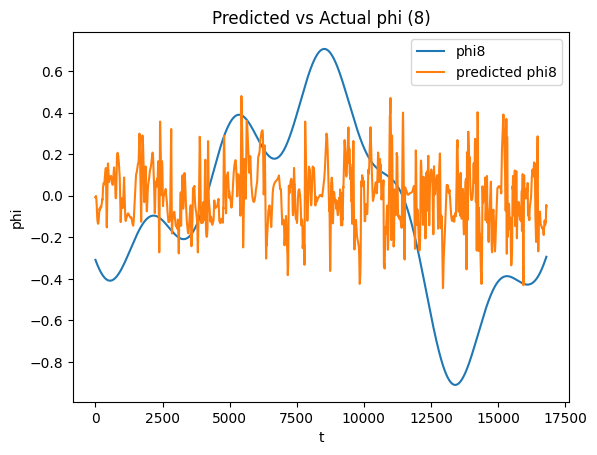

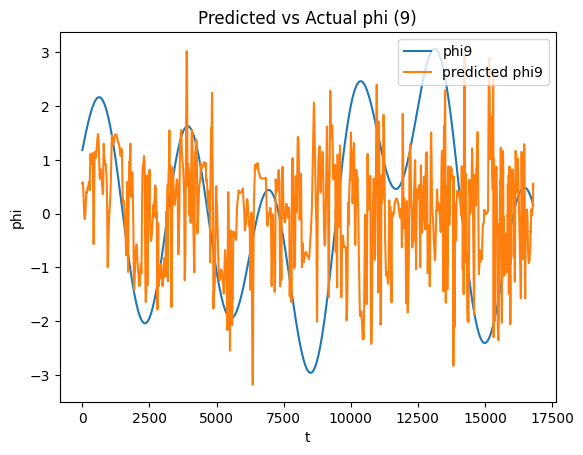

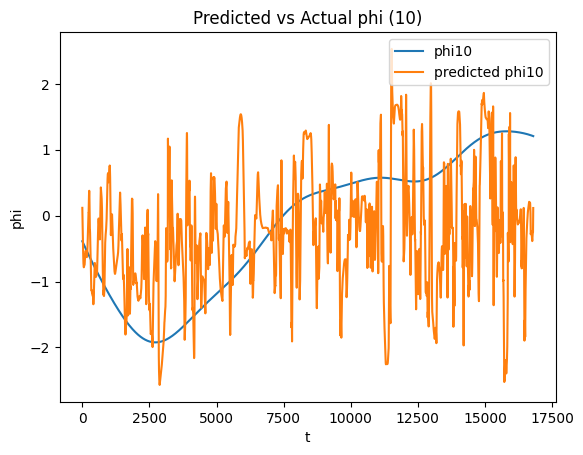

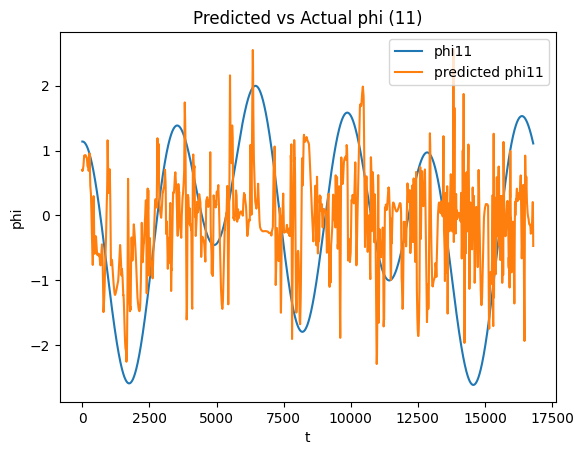

In [41]:
# Plot the MSE
for j in range(12):
    mse_values = []
    for i in range(len(phi_preds)):
        mse = np.mean((phi_preds[i,j] - phi_test[i,j]) ** 2)
        mse_values.append(mse)

    plt.plot(mse_values)
plt.axvline(x=len(PHI) * 0.1, color='red', linestyle='--')
plt.xlabel('t')
plt.ylabel('MSE')
plt.legend(loc='upper left', labels=[f'phi{i}' for i in range(12)])
plt.title('MSE between phi predicted and phi actual')
plt.show()

phi_plot = np.array(PHI)
phi_test = np.array(phi_test)
phi_preds = np.array(phi_preds)
# # Plot the predicted and actual phi
for i in range(12):
    # plt.axvline(x=len(phi_plot) * 0.1, color='red', linestyle='--')
    plt.plot(phi_test[:,i], label=f'phi{i}')
    plt.plot(phi_preds[:,i], label=f'predicted phi{i}')
    plt.xlabel('t')
    plt.ylabel('phi')
    plt.legend(loc='upper right')
    plt.title(f'Predicted vs Actual phi ({i})')
    plt.show()

In [ ]:
QBER_2 = QBER.reshape(QBER.shape[0], 1, QBER.shape[1])
# Predict the QBER using the trained neural network
phi_preds = model.predict(QBER_2[:,:])
phi_preds = np.array(phi_preds)
phi_preds = phi_preds.reshape(phi_preds.shape[0], phi_preds.shape[2])

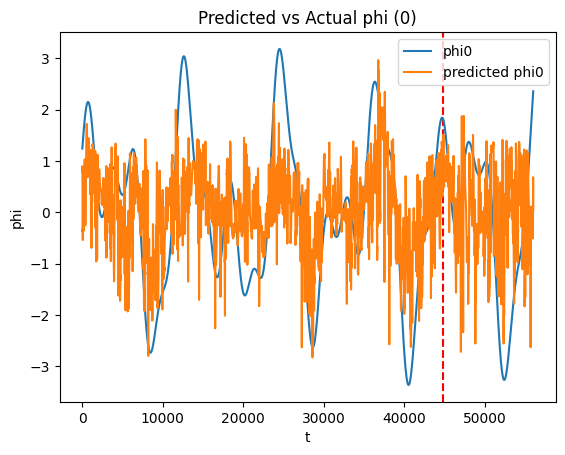

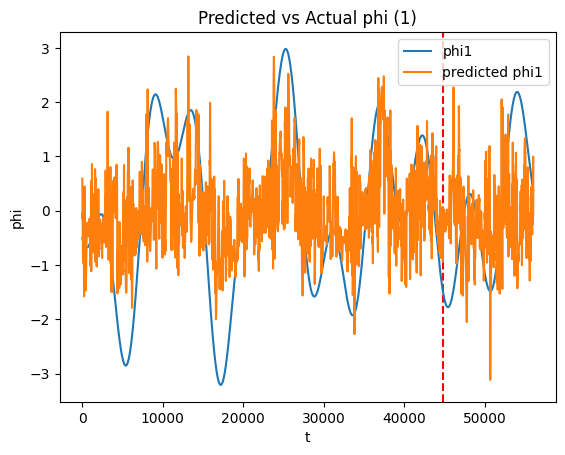

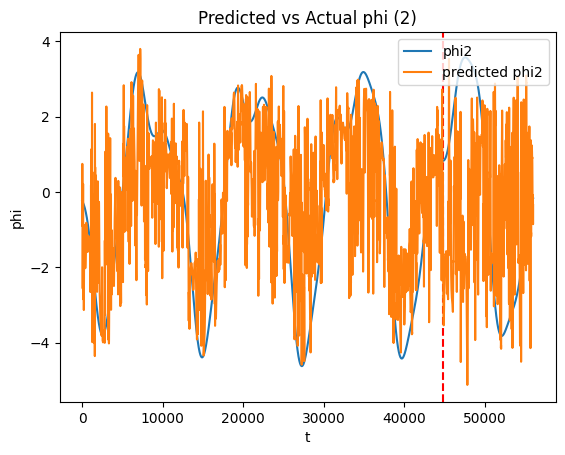

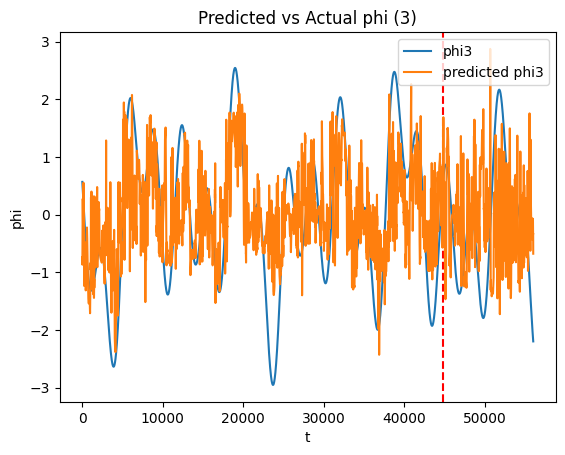

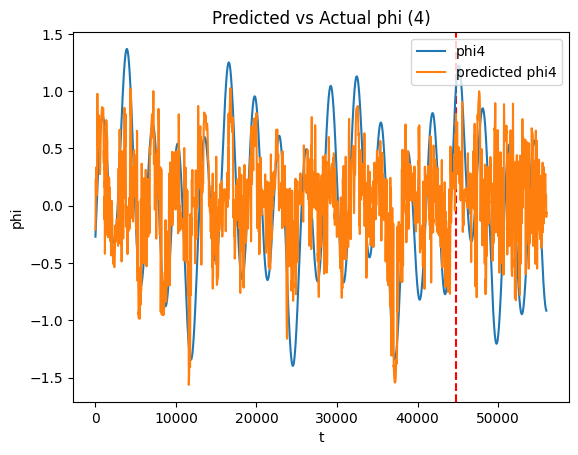

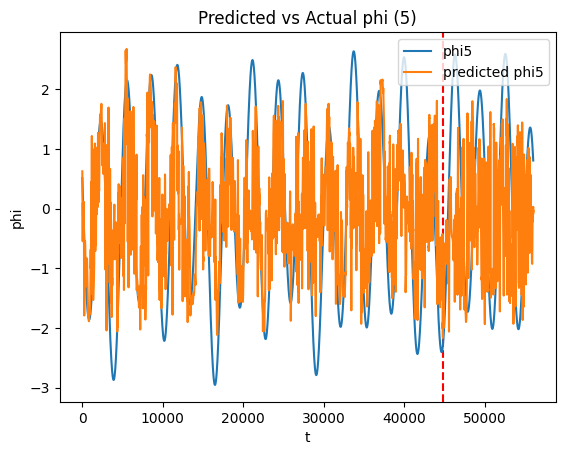

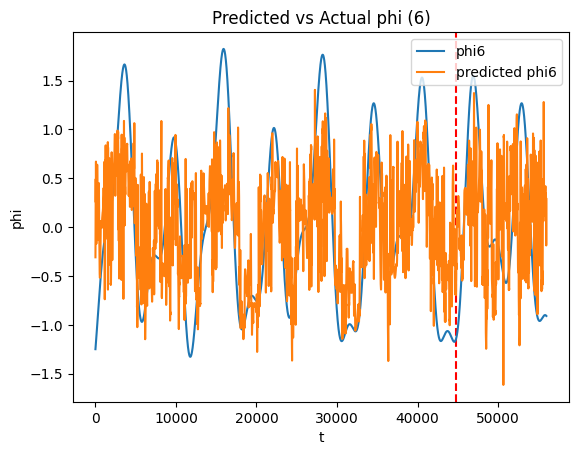

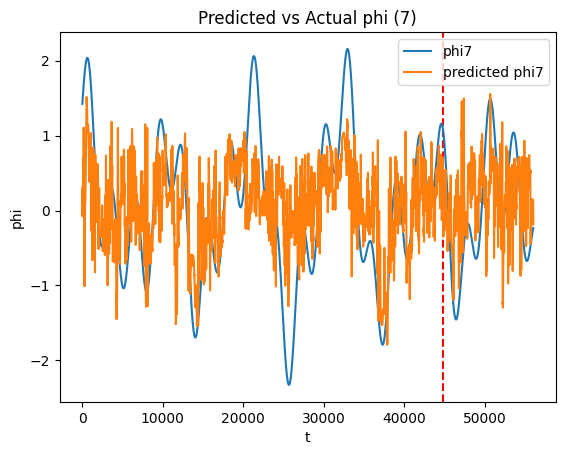

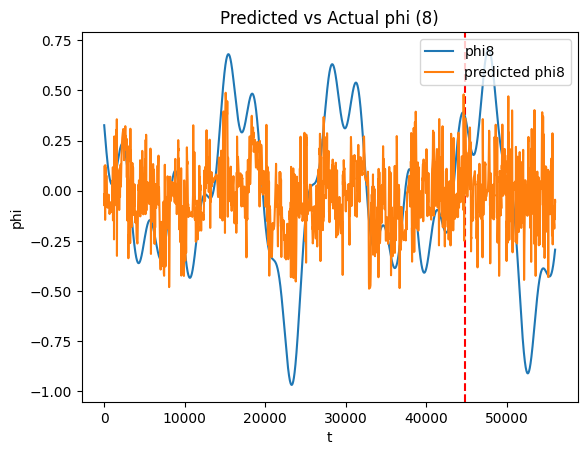

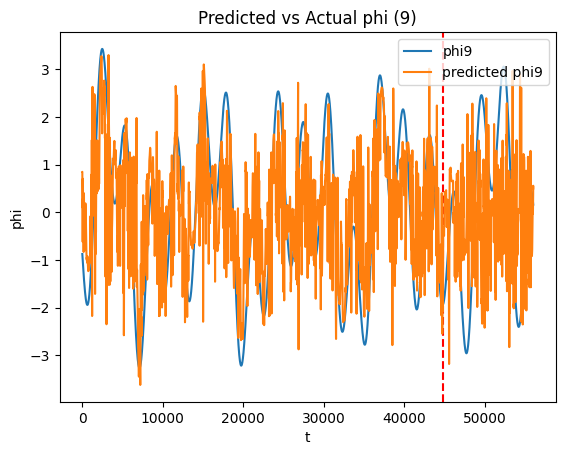

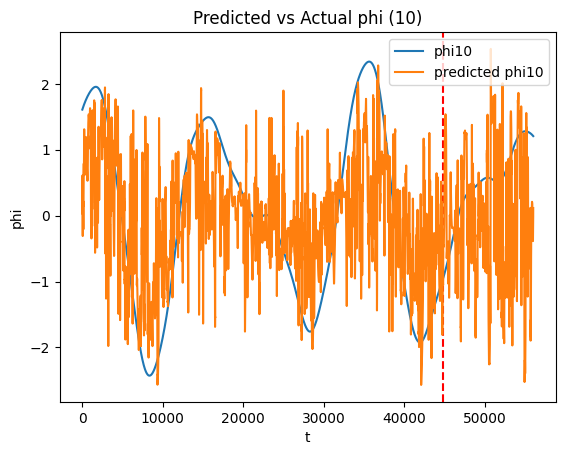

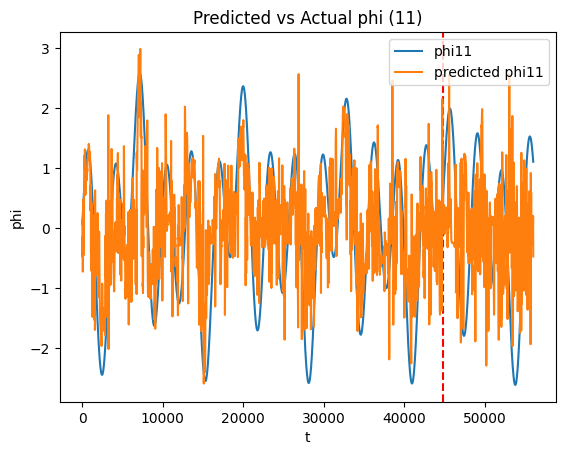

In [50]:

# # Plot the predicted and actual phi
for i in range(12):
    plt.axvline(x=len(phi_plot) * split, color='red', linestyle='--')
    plt.plot(PHI[:,i], label=f'phi{i}')
    plt.plot(phi_preds[:,i], label=f'predicted phi{i}')
    plt.xlabel('t')
    plt.ylabel('phi')
    plt.legend(loc='upper right')
    plt.title(f'Predicted vs Actual phi ({i})')
    plt.show()